### <strong><font color=cornflowerblue>第四次作品：</font></strong>
學號：411078064

姓名：謝意盛
<hr>

### <strong>作品目標</strong>：




<hr>

#### <strong>參考資料</font>：

1. [汪群超 Chun-Chao Wang 老師講義](https://ntpuccw.blog/python-in-learning/sml%e6%b7%ba%e5%ba%a6%e6%a9%9f%e5%99%a8%e5%ad%b8%e7%bf%92%ef%bc%9apca-%e3%80%81svd-%e5%8f%8a%e5%85%b6%e5%9c%a8%e5%bd%b1%e5%83%8f%e8%99%95%e7%90%86%e7%9a%84%e6%87%89%e7%94%a8/)

<hr>

#### <strong>載入套件</strong>：

In [1]:
import os, time, socket
from platform import python_version
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 模型所需套件
from sklearn.model_selection import train_test_split
import torch, cv2
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
# 自定義 module (Deblurring_defs.py)
from Deblurring_defs import  (
    DeblurDataset, DeblurCNN, DeblurCNN_RES, DeblurSuperResCNN, 
    save_decoded_image, psnr
)

print("【日期時間】{}".format(time.strftime("%Y/%m/%d %H:%M:%S")))
print("【工作目錄】{}".format(os.getcwd()))
print("【主機名稱】{} ({})".format(socket.gethostname(),socket.gethostbyname(socket.gethostname())))
print("【Python】{}".format(python_version()))
print("【虛擬環境】{}".format(os.environ.get('VIRTUAL_ENV')))  # 查看使用的虛擬環境


【日期時間】2025/06/05 13:15:17
【工作目錄】d:\ys\B4_ShallowML\ShallowML\HW4\src
【主機名稱】DESKTOP-4767TI4 (192.168.0.131)
【Python】3.11.3
【虛擬環境】D:\ys\B4_ShallowML\ShallowML\env\ShallowML


<hr>
<hr>

### **<font color=cornflowerblue>第 1 步：模型訓練前處理</font>**  



#### 宣告 Global 常數

In [2]:
DIR_PATH = '../'
# IMG_RESIZE = (224, 224) # 注意：將訓練影像大小改為 224x224
IMG_RESIZE = (35, 35) # 注意：依據訓練資料大小不同，將訓練影像大小改為 33x33
BATCH_SIZE = 5
LEARNING_RATE = 0.001 # Learning rate.
NUM_EPOCHS = 10 # Number of epochs to train the model
WEIGHTS_CNN = DIR_PATH + 'outputs/pre_trained_model_cnn.pt' # Path to the pre-trained model
WEIGHTS_RES = DIR_PATH + 'outputs/pre_trained_model_res.pt' # Path to the pre-trained model
WEIGHTS_SPRES = DIR_PATH + 'outputs/pre_trained_model_spres.pt' # Path to the pre-trained model

blur_path = DIR_PATH + 'inputs/T91_blurred_patches' # Directory containing the blurred images
sharp_path = DIR_PATH + 'inputs/T91_sharp_patches' # Directory containing the sharp images

# Create the directory to save the images if it doesn't exist
image_dir = DIR_PATH + 'outputs/saved_images' # Directory to save validation images during training
os.makedirs(image_dir, exist_ok=True)

# 平行運算
# torch.set_num_threads(16)  # 使用 4 顆 CPU 執行緒


#### 設定 CNN 模型（三選一）

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print('Using {} device'.format(device))

model = DeblurCNN().to(device)
# model = DeblurCNN_RES().to(device)
# model = DeblurSuperResCNN().to(device)

print(f"Model: {model}")

total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")

total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

lr = LEARNING_RATE # Learning rate.
optimizer = optim.Adam(model.parameters(), lr=lr)
print(f"Learning rate: {lr}")
print(f"Optimizer: {optimizer}")
# Loss function.
criterion = nn.MSELoss()
print(f"Loss function: {criterion}")

# scheduler is to reduce the learning rate when a monitored metric (like validation loss) stops improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
        optimizer,
        mode='min',
        patience=5,
        factor=0.5,
        # verbose=True
    )


Using cpu device
Model: DeblurCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (output_layer): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
147,043 total parameters.
147,043 training parameters

#### 繼續先前訓練的模型（若有）

In [15]:
# WEIGHTS_CNN, WEIGHTS_RES, WEIGHTS_SPRES
if isinstance(model, DeblurCNN):
    WEIGHTS = WEIGHTS_CNN
    print("目前使用的是 DeblurCNN 模型")
elif isinstance(model, DeblurCNN_RES):
    WEIGHTS = WEIGHTS_RES
    print("目前使用的是 DeblurCNN_RES 模型")
else:
    WEIGHTS = WEIGHTS_SPRES
    print("目前使用的是 DeblurSuperResCNN 模型")

# resume training if weights are present.
if os.path.exists(WEIGHTS):
    print('Weights file found. Resuming training...')

    checkpoint = torch.load(WEIGHTS)
    print("Resuming the model state...")
    model.load_state_dict(checkpoint['model_state_dict'])
    pre_trained_epoch = checkpoint['epoch']
    print(f"Resuming training from epoch: {pre_trained_epoch}")
    # Load the optimizer state if available. may not be good idea to resume.
    print("Resuming the optimizer state...")
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    pre_trained_epoch = 0
    print('No pre-trained file found. Starting training from scratch...')
print(f"Current Model: {model}")


目前使用的是 DeblurCNN 模型
Weights file found. Resuming training...
Resuming the model state...
Resuming training from epoch: 10
Resuming the optimizer state...
Current Model: DeblurCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU

#### 準備訓練與測試資料

In [5]:
gauss_blur = os.listdir(blur_path)
gauss_blur.sort()
sharp = os.listdir(sharp_path)
sharp.sort()
x_blur = [] # images names for gauss blurred images
for i in range(len(gauss_blur)):
    x_blur.append(gauss_blur[i])
y_sharp = [] # images names for sharp images
for i in range(len(sharp)):
    y_sharp.append(sharp[i])

(x_train, x_val, y_train, y_val) = train_test_split(x_blur, y_sharp, test_size=0.1)
print(f"Train data instances: {len(x_train)}")
print(f"Validation data instances: {len(x_val)}")

# define transforms to resize and convert images to tensor
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_RESIZE), # Resize images to IMG_RESIZE for training
    transforms.ToTensor(),
])

train_data = DeblurDataset(blur_path, x_train, sharp_path, y_train, transform)
val_data = DeblurDataset(blur_path, x_val, sharp_path, y_val, transform)
 
 
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=1, shuffle=False)
# trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
# valloader = DataLoader(val_data, batch_size=1, shuffle=False, num_workers=8)

Train data instances: 19548
Validation data instances: 2173


#### 定義函數——模型訓練步驟

In [6]:
def fit(model, dataloader, epoch):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        blur_image = data[0]
        sharp_image = data[1]
        blur_image = blur_image.to(device)
        sharp_image = sharp_image.to(device)
        optimizer.zero_grad()
        outputs = model(blur_image)
        loss = criterion(outputs, sharp_image)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        running_loss += loss.item()
        running_psnr +=  psnr(sharp_image, outputs)
    
    train_loss = running_loss/len(dataloader.dataset)
    train_psnr = running_psnr/len(dataloader)
    print(f"Train Loss: {train_loss:.5f} - Train PSNR: {train_psnr:.2f} dB")
    # print(f"Train Loss: {train_loss:.5f}")
    
    return train_loss, train_psnr

#### 定義函數——模型測試步驟

In [7]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            blur_image = data[0]
            sharp_image = data[1]
            blur_image = blur_image.to(device)
            sharp_image = sharp_image.to(device)
            outputs = model(blur_image)
            loss = criterion(outputs, sharp_image)
            running_loss += loss.item()
            running_psnr +=  psnr(sharp_image, outputs)
            # # ---- This part should be removed for large epochs ----
            # if epoch == 0 and i == int((len(val_data)/dataloader.batch_size)-2):
            #     save_decoded_image(sharp_image.cpu().data, name = f"{image_dir}/sharp{epoch}.jpg", size=IMG_RESIZE)
            #     save_decoded_image(blur_image.cpu().data, name = f"{image_dir}/blur{epoch}.jpg", size=IMG_RESIZE)
            #     save_decoded_image(outputs.cpu().data, name = f"{image_dir}/deblurred{epoch}.jpg", size=IMG_RESIZE)
            # if i == int((len(val_data)/dataloader.batch_size)-2): 
            #     save_decoded_image(outputs.cpu().data, name = f"{image_dir}/val_deblurred{epoch}.jpg", size=IMG_RESIZE)
            # # ------------------------------------------------------
            
        val_loss = running_loss/len(dataloader.dataset)
        val_psnr = running_psnr/len(dataloader)
        print(f"Val Loss: {val_loss:.5f} - Val PSNR: {val_psnr:.2f} dB")
        
        return val_loss, val_psnr

<hr>
<hr>

### **<font color=cornflowerblue>第 2 步：開始模型訓練</font>**  



#### 進行訓練

In [16]:
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start_time = time.time()
epochs = NUM_EPOCHS
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    
    train_epoch_loss, train_epoch_psnr = fit(model, trainloader, epoch)
    val_epoch_loss, val_epoch_psnr = validate(model, valloader, epoch)
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
    scheduler.step(val_epoch_loss)

end_time = time.time()
print(f"Took {((end_time-start_time)/60):.3f} minutes to train")
print('Saving model...')
# save the model
cumulative_epochs = epochs + pre_trained_epoch

# WEIGHTS_CNN, WEIGHTS_RES, WEIGHTS_SPRES
torch.save({
    'epoch': cumulative_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, WEIGHTS)
print(f"Model saved as {WEIGHTS}")

# 1st 34m31.2s


Epoch 1 of 10


100%|██████████| 3910/3910 [05:01<00:00, 12.98it/s]


Train Loss: 0.00077 - Train PSNR: 24.72 dB


100%|██████████| 2173/2173 [00:35<00:00, 60.95it/s]


Val Loss: 0.00306 - Val PSNR: 26.80 dB
Epoch 2 of 10


100%|██████████| 3910/3910 [01:28<00:00, 44.14it/s]


Train Loss: 0.00076 - Train PSNR: 24.77 dB


100%|██████████| 2173/2173 [00:06<00:00, 344.18it/s]


Val Loss: 0.00266 - Val PSNR: 27.86 dB
Epoch 3 of 10


100%|██████████| 3910/3910 [01:29<00:00, 43.80it/s]


Train Loss: 0.00072 - Train PSNR: 24.99 dB


100%|██████████| 2173/2173 [00:06<00:00, 334.48it/s]


Val Loss: 0.00281 - Val PSNR: 27.31 dB
Epoch 4 of 10


100%|██████████| 3910/3910 [01:30<00:00, 43.40it/s]


Train Loss: 0.00074 - Train PSNR: 24.90 dB


100%|██████████| 2173/2173 [00:06<00:00, 356.88it/s]


Val Loss: 0.00286 - Val PSNR: 27.14 dB
Epoch 5 of 10


100%|██████████| 3910/3910 [01:51<00:00, 35.08it/s]


Train Loss: 0.00072 - Train PSNR: 25.00 dB


100%|██████████| 2173/2173 [00:06<00:00, 312.47it/s]


Val Loss: 0.00275 - Val PSNR: 27.45 dB
Epoch 6 of 10


100%|██████████| 3910/3910 [01:33<00:00, 41.72it/s]


Train Loss: 0.00072 - Train PSNR: 25.04 dB


100%|██████████| 2173/2173 [00:06<00:00, 344.88it/s]


Val Loss: 0.00263 - Val PSNR: 27.84 dB
Epoch 7 of 10


100%|██████████| 3910/3910 [01:31<00:00, 42.94it/s]


Train Loss: 0.00071 - Train PSNR: 25.04 dB


100%|██████████| 2173/2173 [00:06<00:00, 351.05it/s]


Val Loss: 0.00276 - Val PSNR: 27.40 dB
Epoch 8 of 10


100%|██████████| 3910/3910 [01:30<00:00, 43.43it/s]


Train Loss: 0.00071 - Train PSNR: 25.10 dB


100%|██████████| 2173/2173 [00:07<00:00, 284.75it/s]


Val Loss: 0.00263 - Val PSNR: 27.82 dB
Epoch 9 of 10


100%|██████████| 3910/3910 [01:38<00:00, 39.83it/s]


Train Loss: 0.00070 - Train PSNR: 25.15 dB


100%|██████████| 2173/2173 [00:06<00:00, 338.89it/s]


Val Loss: 0.00271 - Val PSNR: 27.59 dB
Epoch 10 of 10


100%|██████████| 3910/3910 [01:26<00:00, 45.13it/s]


Train Loss: 0.00069 - Train PSNR: 25.21 dB


100%|██████████| 2173/2173 [00:06<00:00, 357.09it/s]

Val Loss: 0.00282 - Val PSNR: 27.31 dB
Took 20.572 minutes to train
Saving model...
Model saved as ../outputs/pre_trained_model_cnn.pt


#### 畫出每一輪 epochs 的 Loss 和 PSNR 的趨勢圖

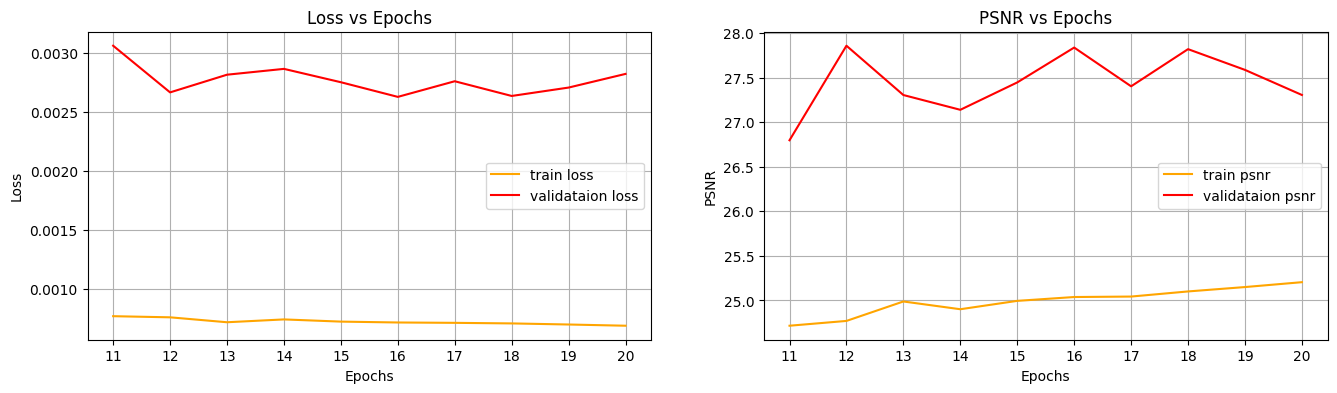

In [19]:
# loss plots
if isinstance(model, DeblurCNN):
    FIG_PATH = f'outputs/loss_psnr_cnn_{cumulative_epochs}.png'
elif isinstance(model, DeblurCNN_RES):
    FIG_PATH = f'outputs/loss_psnr_res_{cumulative_epochs}.png'
else:
    FIG_PATH = f'outputs/loss_psnr_spres_{cumulative_epochs}.png'

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(train_loss, color='orange', label='train loss')
ax[0].plot(val_loss, color='red', label='validataion loss')

num_points = len(train_loss)
num_ticks = 10 if num_points >= 10 else num_points
tick_positions = np.linspace(0, num_points-1, num_ticks, dtype=int)
tick_labels = [pre_trained_epoch + i + 1 for i in tick_positions]
ax[0].set_xticks(ticks=tick_positions, labels=tick_labels)

ax[0].set_title('Loss vs Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(train_psnr, color='orange', label='train psnr')
ax[1].plot(val_psnr, color='red', label='validataion psnr')
ax[1].set_xticks(ticks=tick_positions, labels=tick_labels)
ax[1].set_title('PSNR vs Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('PSNR')
ax[1].legend()
ax[1].grid()

plt.savefig(DIR_PATH + FIG_PATH)
plt.show()


<hr>
<hr>

### **<font color=cornflowerblue>第 3 步：模型測試</font>**  



<font color=skyblue>產品展示</font>

- 輸入任意圖像
- 先進行高斯模糊化
- 轉換模糊圖像矩陣為 tensor 矩陣
- 再送入已訓練好之 CNN 模型得到去除模糊圖像
- 轉換去除模糊圖像為 numpy 矩陣
- 最後呈現模型的表現。

#### 測試模型效果

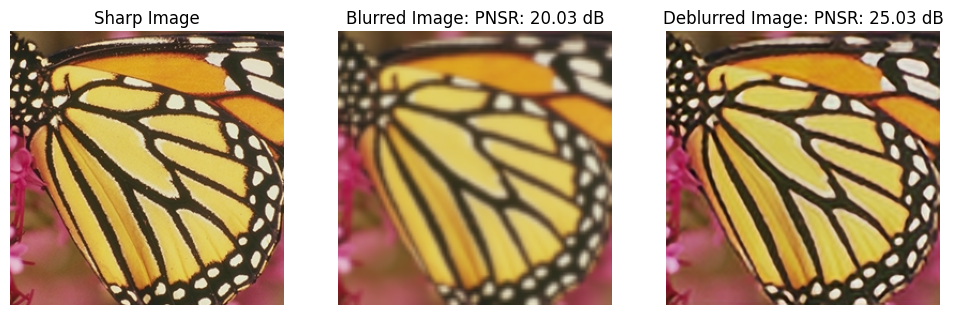

In [20]:
# load an image from pictures directory
sharp = cv2.imread('../inputs/Set5/butterfly.PNG', cv2.IMREAD_COLOR)
sharp = cv2.cvtColor(sharp, cv2.COLOR_BGR2RGB)
sharp_tensor = transforms.ToPILImage()(sharp)
sharp_tensor = transforms.ToTensor()(sharp_tensor)
sharp_tensor = sharp_tensor.unsqueeze(0) # add batch dimension
# add gaussian blurring
blur = cv2.GaussianBlur(sharp, (7, 7), 0)
height, width = blur.shape[:2]
small = cv2.resize(blur, (width // 3, height // 3), interpolation=cv2.INTER_AREA)
restored = cv2.resize(small, (width, height), interpolation=cv2.INTER_LINEAR)
# convert the blur to tensor without resizing
blur_tensor = transforms.ToPILImage()(restored)
blur_tensor = transforms.ToTensor()(blur_tensor)
blur_tensor = blur_tensor.unsqueeze(0) # add batch dimension
blur_tensor = blur_tensor.to(device)

# deblur the image
with torch.no_grad():
    deblurred_tensor = model(blur_tensor)

psnr_blur = psnr(sharp_tensor, blur_tensor)
psnr_deblur = psnr(sharp_tensor, deblurred_tensor)

# 畫圖
if isinstance(model, DeblurCNN):
    FIG_PATH_TEST = f'outputs/test_cnn_{cumulative_epochs}.png'
elif isinstance(model, DeblurCNN_RES):
    FIG_PATH_TEST = f'outputs/test_res_{cumulative_epochs}.png'
else:
    FIG_PATH_TEST = f'outputs/test_spres_{cumulative_epochs}.png'

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
img0 = blur_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
img1 = deblurred_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()

# Clip to [0, 1] if float, or [0, 255] if uint8
img0 = np.clip(img0, 0, 1)
img1 = np.clip(img1, 0, 1)

ax[0].imshow(sharp)
ax[0].set_title('Sharp Image')
ax[0].axis('off')
ax[1].imshow(img0)
ax[1].set_title('Blurred Image: PNSR: {:.2f} dB'.format(psnr_blur))
ax[1].axis('off')
ax[2].imshow(img1)
ax[2].set_title('Deblurred Image: PNSR: {:.2f} dB'.format(psnr_deblur))
ax[2].axis('off')
plt.savefig(DIR_PATH + FIG_PATH_TEST)
plt.show()
